In [411]:
# Question to answer:
# In which groups are makos patents
# Split group of patents by year

# Get Strykper patents - see if any inventor from MAKO was in any patents

The data has been extracted from Google BigSQL using the following query:

```
select s.assignee , s.publication_number, s.filing_date, s.publication_date, s.inventor_harmonized, s.ipc, s.grant_date 
FROM `patents-public-data.patents.publications` as s
where (
  'Stryker European Holdings I, LLC' in unnest(s.assignee)  or
  'Stryker Corporation' in unnest(s.assignee) or
  'Stryker Nv Operations Limited' in unnest(s.assignee) or
  'Stryker European Holdings I, Llc' in unnest(s.assignee) or
  'Stryker Leibinger Gmbh & Co. Kg' in unnest(s.assignee) or
  'Stryker Technologies Corporation' in unnest(s.assignee) or
  'Stryker France S.A.' in unnest(s.assignee) or
  'Stryker Leibinger Gmbh & Co., Kg' in unnest(s.assignee) or
  'Stryker European Holdings Vi, Llc' in unnest(s.assignee) or
  'Stryker Spine' in unnest(s.assignee) or
  'Mako Surgical Corp.' in unnest(s.assignee) or
  'Mako Surgical Corporation' in unnest(s.assignee)
 )
 ````



In [622]:
import pandas as pd
import json

import seaborn as sns;
sns.set()

from matplotlib import pyplot as plt
from wipo_ipc import Ipc

%matplotlib inline

In [650]:
def extract_ipc(ipc):
    if(len(ipc) == 0):
        return ""
    first = [b['code'] for b in ipc if b['first'] == True]
    if(len(first) == 0):
        first = ipc[0]['code']
    else:
        first = first[0]
    return first

pub_ipc = []
with open('patents_mako.json') as f:
    js_file = json.load(f)
    for x in js_file:
        pub_nr = x['publication_number']
        ipc = x['ipc']
        if(ipc):
            ipc_code = extract_ipc(ipc)
            pub_ipc.append({'nr': pub_nr, 
                            'ipc': ipc_code, 
                            'filing_year': x['filing_date'][:4], 
                            'grant_year': True if x['grant_date'] != '0' else False
                           })

In [657]:
df_pub_ipc = pd.DataFrame.from_dict(pub_ipc)
df_pub_ipc['main_ipc'] = df_pub_ipc.ipc.apply(lambda x: x[:3])

ipc_to_desc = {}
for x in df_pub_ipc.main_ipc.unique():
    my_ipc = Ipc(x)
    l = my_ipc.classe
    ipc_to_desc[l.code] = l.code + " " + l.description
# too long
ipc_to_desc['F16'] = 'F16 ENGINEERING ELEMENTS OR UNITS'
ipc_to_desc['G16'] = 'G16 ICT SPECIALLY ADAPTED FOR SPECIFIC APPLICATION FIELDS'
ipc_to_desc['G03'] = 'G03 PHOTOGRAPHY; CINEMATOGRAPHY'
ipc_to_desc['B25'] = 'B25 HAND TOOLS; PORTABLE POWER-DRIVEN TOOLS'
ipc_to_desc
df_pub_ipc.main_ipc = df_pub_ipc.main_ipc.replace(ipc_to_desc)

In [661]:
df_pub_ipc.groupby('grant_year').count()

,filing_year,ipc,nr,main_ipc
grant_year,,,,
False,505,505,505,505
True,251,251,251,251


Text(0, 0.5, 'Number of patents filed')

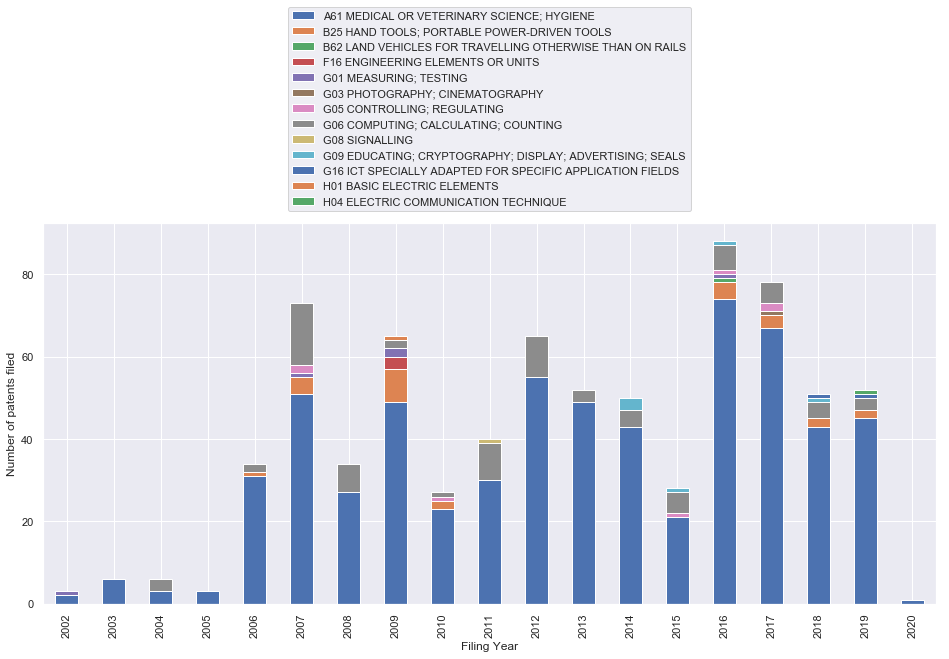

In [741]:
# Plot 1 - all
ax = df_pub_ipc.groupby(['main_ipc', 'filing_year'])['nr'] \
    .count().unstack('main_ipc').fillna(0) \
    .plot.bar(stacked=True, figsize=(16, 7))

ax.legend(loc='center',bbox_to_anchor=(0.50, 1.3));
ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents filed")

Text(0, 0.5, 'Number of patents granted')

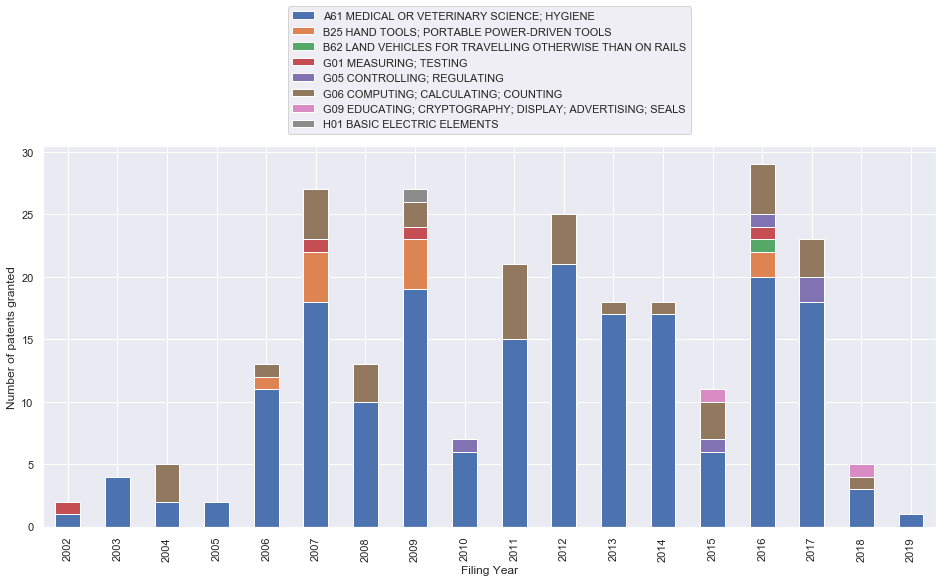

In [745]:
# only granted

# Plot 1 - all
df_granted = df_pub_ipc[df_pub_ipc.grant_year == True]
ax = df_granted.groupby(['main_ipc', 'filing_year'])['nr'] \
    .count().unstack('main_ipc').fillna(0) \
    .plot.bar(stacked=True, figsize=(16, 7))

ax.legend(loc='center',bbox_to_anchor=(0.50, 1.2));
ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents granted")

In [407]:
df_medical = df_pub_ipc[df_pub_ipc.main_ipc == 'A61 MEDICAL OR VETERINARY SCIENCE; HYGIENE']

Text(0, 0.5, 'Number of patents filed')

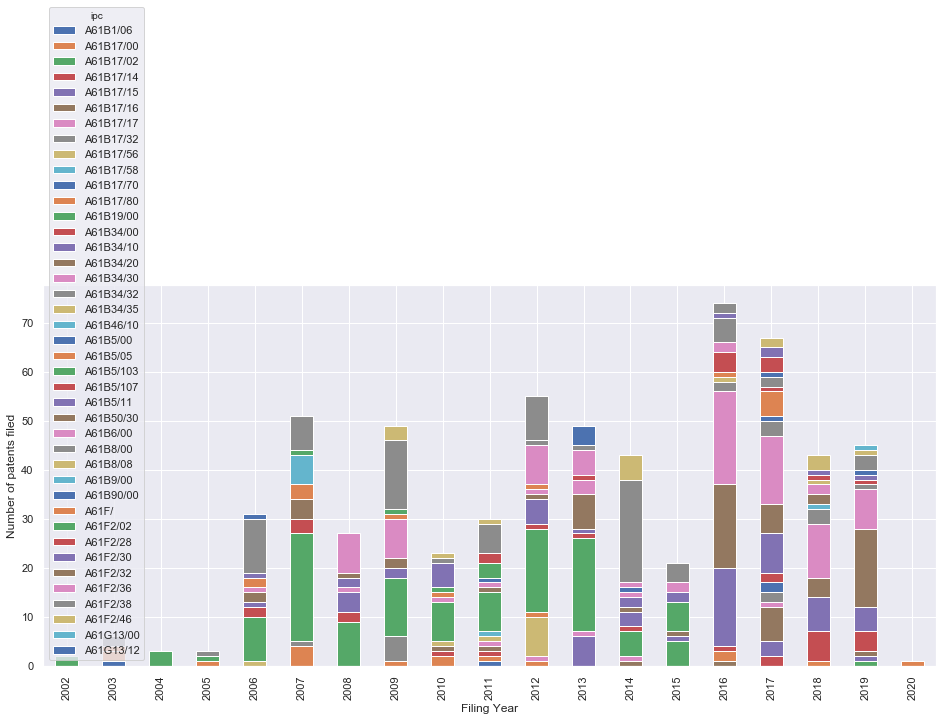

In [410]:
ax = df_medical.groupby(['ipc', 'filing_year' ])['nr'] \
    .count().unstack('ipc').fillna(0) \
    .plot.bar(stacked=True, figsize=(16, 7), fig=f.gca())

ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents filed")

In [601]:
def to_sub_class(x):
    if(x == 'A61B19/00'):
        return 'Instruments, implements or accessories for surgery [..]'.title()
    if(x == 'A61F/'):
        return 'not grouped'.title()
    
    last = x.split('/')[1]
    actual = x[:4] + str(x[4:-(len(last)+1)]).zfill(4) + str(last).ljust(6, '0')
    try:
        r = Ipc(actual).subclass.description
        if(r.startswith('DIAGNOSIS; SURGERY')):
            return "DIAGNOSIS; SURGERY".title()
        if(r.startswith('FILTERS IMPLANTABLE INTO BLOOD VESSELS')):
            return "FILTERS IMPLANTABLE INTO BLOOD VESSELS".title()
        if(r.startswith('TRANSPORT, PERSONAL CONVEYANCES')):
            return "TRANSPORT, PERSONAL CONVEYANCES [..]".title()
        else: 
            return r
    except ValueError:
        return -1

df_medical['subclass'] =  df_medical.ipc.apply(lambda x : to_sub_class(x))

/Users/kiru/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0, 0.5, 'Number of patents filed')

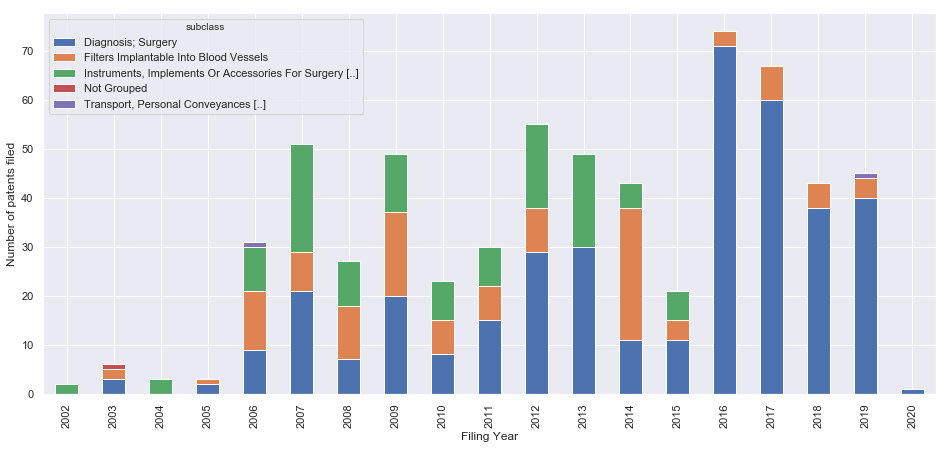

In [602]:
ax = df_medical.groupby(['subclass', 'filing_year' ])['nr'] \
    .count().unstack('subclass').fillna(0) \
    .plot.bar(stacked=True, figsize=(16, 7))

ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents filed")

{'A61B50/30', 'A61B17/70', 'A61F2/28', 'A61B8/08', 'A61B34/32', 'A61B34/35', 'A61G13/00', 'A61B46/10'}


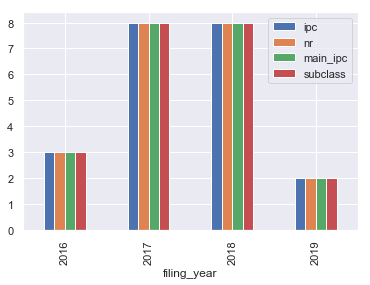

In [667]:
# new categories
before_2016 = df_medical[df_medical.filing_year.astype(int) < 2016].ipc.unique()
after_2016 = df_medical[df_medical.filing_year.astype(int) >= 2016].ipc.unique()
print(set(after_2016) - set(before_2016))
df_medical[df_medical.ipc.isin(set(after_2016) - set(before_2016))].groupby('filing_year').count().plot.bar()

patents.json qeury: 
    
```
select s.assignee , s.publication_number, s.filing_date, s.publication_date, s.inventor_harmonized, s.ipc, s.grant_date 
FROM `patents-public-data.patents.publications` as s
where (
  'Stryker European Holdings I, LLC' in unnest(s.assignee)  or
  'Stryker Corporation' in unnest(s.assignee) or
  'Stryker Nv Operations Limited' in unnest(s.assignee) or
  'Stryker European Holdings I, Llc' in unnest(s.assignee) or
  'Stryker Leibinger Gmbh & Co. Kg' in unnest(s.assignee) or
  'Stryker Technologies Corporation' in unnest(s.assignee) or
  'Stryker France S.A.' in unnest(s.assignee) or
  'Stryker Leibinger Gmbh & Co., Kg' in unnest(s.assignee) or
  'Stryker European Holdings Vi, Llc' in unnest(s.assignee) or
  'Stryker Spine' in unnest(s.assignee) or
  'Mako Surgical Corp.' in unnest(s.assignee) or
  'Mako Surgical Corporation' in unnest(s.assignee)
 )
```

In [687]:
# Stryker patents
stryker_mako = []
all_patents = []
with open('patents.json') as f:
    for cnt, line in enumerate(f):
        result = json.loads(line)
        assignee = "Mako"
        ipc = extract_ipc(result['ipc'])
        if([x for x in result['assignee'] if x.lower().find("mako") != -1] == []):
            assignee = "Stryker"
        all_patents.append({
            'nr': result['publication_number'], 
            'filing_year': result['filing_date'][:4],
            'assignee': assignee, 
            'ipc': ipc, 
            'grant_year': True if result['grant_date'] != '0' else False
        })    

In [692]:
df_all = pd.DataFrame.from_dict(all_patents)
print(len(df_all))
print(len(df_all[df_all.grant_year == True]))

7266
3119


Text(0, 0.5, 'Number of patents filed')

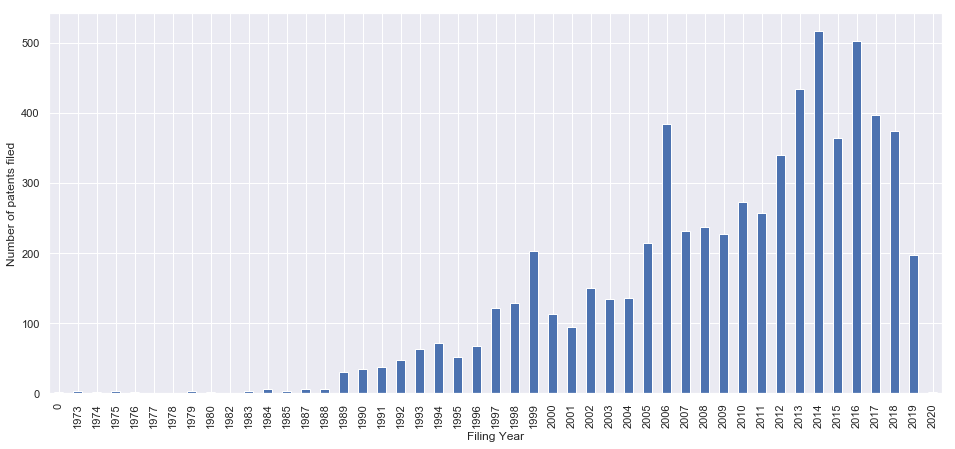

In [676]:
# Plot 3

ax = df_all[df_all.assignee == 'Stryker'].groupby('filing_year')['nr'] \
    .count().plot.bar( figsize=(16, 7))
ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents filed")

In [694]:
df_all['main_ipc'] = df_pub_ipc.ipc.apply(lambda x: x[:3])
df_all.main_ipc = df_pub_ipc.main_ipc.replace(ipc_to_desc)

Text(0, 0.5, 'Number of patents filed')

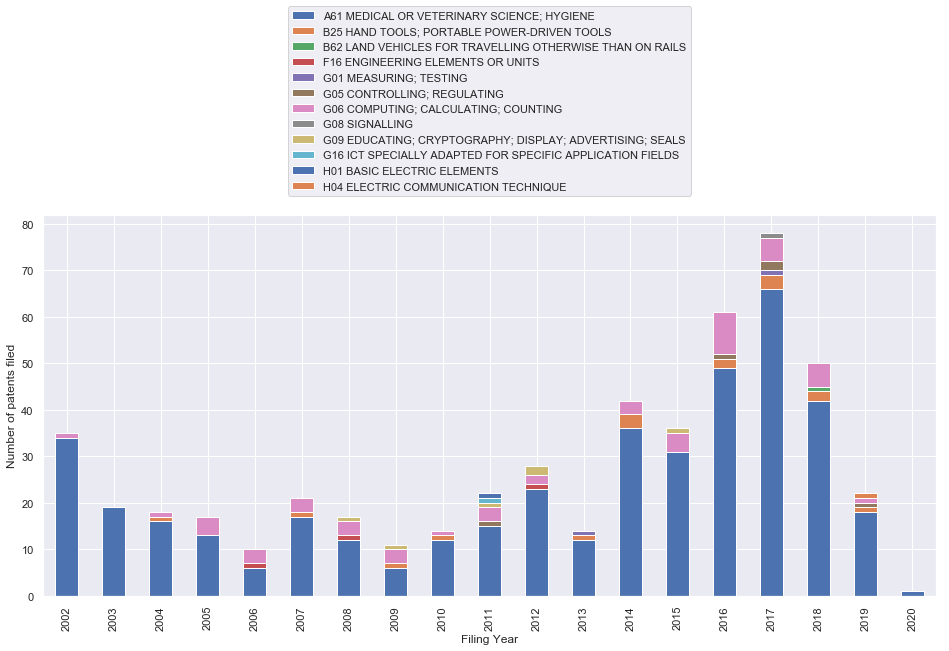

In [746]:
df_all_new = df_all[df_all.filing_year.astype(int) >= 2002]
ax = df_all_new.groupby(['main_ipc', 'filing_year' ])['nr'] \
    .count().unstack('main_ipc').fillna(0) \
    .plot.bar(stacked=True, figsize=(16, 7))

ax.legend(loc='center',bbox_to_anchor=(0.50, 1.3));
ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents filed")

Text(0, 0.5, 'Number of patents filed')

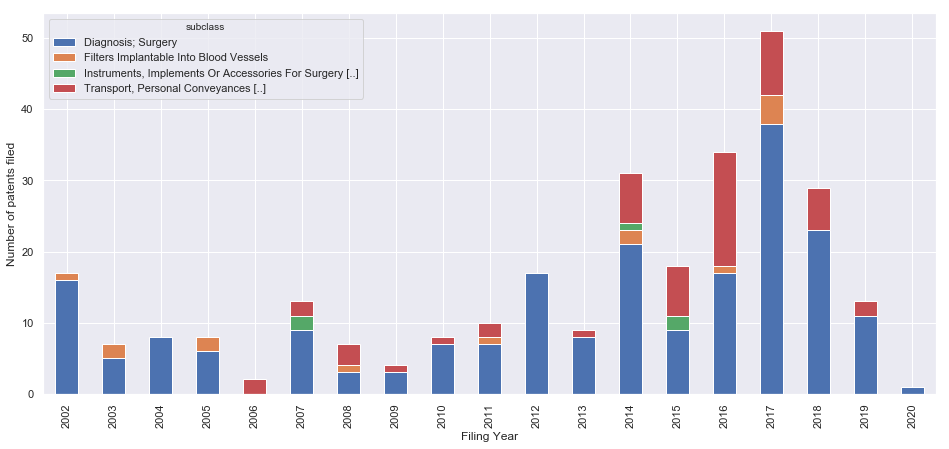

In [720]:
df_all_new = df_all[df_all.filing_year.astype(int) >= 2002]
df_all_new_a61 = df_all_new[df_all_new.main_ipc == 'A61 MEDICAL OR VETERINARY SCIENCE; HYGIENE'].copy()
df_all_new_a61['subclass'] =  df_all_new_a61.ipc.apply(lambda x : to_sub_class(x))
df_all_new_a61 = df_all_new_a61[df_all_new_a61.subclass.isin(df_medical.subclass.unique())]

ax = df_all_new_a61.groupby(['subclass', 'filing_year' ])['nr'] \
    .count().unstack('subclass').fillna(0) \
    .plot.bar(stacked=True, figsize=(16, 7))

ax.set_xlabel("Filing Year")
ax.set_ylabel("Number of patents filed")

428

Stryker - mako citing

```
select
  b.year, 
  sum(b.m_c_s) as marko_cits_stryker, 
  sum(b.s_c_m) as stryker_cits_marko
from (
  select 
    distinct m.publication_number, 
    substr(cast (m.filing_date as STRING), 0, 4) as year, 
   (select count(*) from unnest(m.citation) as x where x.publication_number  = s.publication_number ) as m_c_s, 
   (select count(*) from unnest(s.citation) as x where x.publication_number  = m.publication_number ) as s_c_m
  FROM `patents-public-data.patents.publications` as s, `patents-public-data.patents.publications` as m
  where (
    'Stryker European Holdings I, LLC' in unnest(s.assignee)  or
    'Stryker Corporation' in unnest(s.assignee) or
    'Stryker Nv Operations Limited' in unnest(s.assignee) or
    'Stryker European Holdings I, Llc' in unnest(s.assignee) or
    'Stryker Leibinger Gmbh & Co. Kg' in unnest(s.assignee) or
    'Stryker Technologies Corporation' in unnest(s.assignee) or
    'Stryker France S.A.' in unnest(s.assignee) or
    'Stryker Leibinger Gmbh & Co., Kg' in unnest(s.assignee) or
    'Stryker European Holdings Vi, Llc' in unnest(s.assignee) or
    'Stryker Spine' in unnest(s.assignee)
    ) 
    and (
    'Mako Surgical Corp.' in unnest(m.assignee) or
    'Mako Surgical Corporation' in unnest(m.assignee)
    )
 ) b
group by b.year
````


In [747]:
df_cites = pd.read_csv('stryker_mako_citing.csv', parse_dates=False, names=['year', 'MAKO Cited STRYKER', 'STRYKER cited MAKO'], skiprows=1)
df_cites

,year,MAKO Cited STRYKER,STRYKER cited MAKO
0,2013,2,2
1,2010,1,9
2,2012,1,4
3,2008,0,9
4,2015,5,4
5,2019,6,1
6,2007,2,15
7,2011,3,14
8,2004,0,0
9,2017,15,2


Text(0, 0.5, '#Nr of Citings')

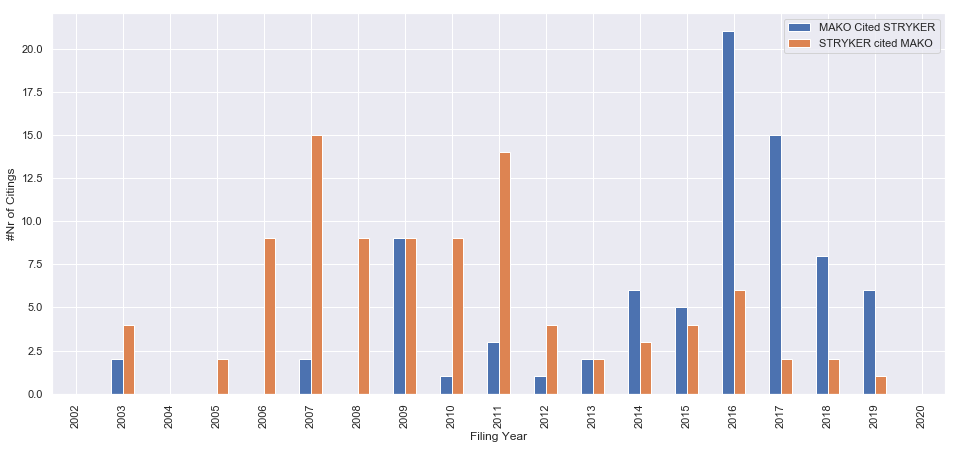

In [584]:
ax = df_cites.set_index('year') \
    .sort_index() \
    .plot.bar(figsize=(16, 7))
ax.set_xlabel("Filing Year")
ax.set_ylabel("#Nr of Citings")

Query to get inventor who moved: 
```¨
select 
   distinct b.nr
from (
  select 
    m.publication_number as nr, 
    substr(cast (m.filing_date as STRING), 0, 4) as year, 
    m.inventor_harmonized
  FROM `patents-public-data.patents.publications` as s, `patents-public-data.patents.publications` as m
  where (
    'Stryker European Holdings I, LLC' in unnest(s.assignee)  or
    'Stryker Corporation' in unnest(s.assignee) or
    'Stryker Nv Operations Limited' in unnest(s.assignee) or
    'Stryker European Holdings I, Llc' in unnest(s.assignee) or
    'Stryker Leibinger Gmbh & Co. Kg' in unnest(s.assignee) or
    'Stryker Technologies Corporation' in unnest(s.assignee) or
    'Stryker France S.A.' in unnest(s.assignee) or
    'Stryker Leibinger Gmbh & Co., Kg' in unnest(s.assignee) or
    'Stryker European Holdings Vi, Llc' in unnest(s.assignee) or
    'Stryker Spine' in unnest(s.assignee)
    ) 
    and (
      'Mako Surgical Corp.' in unnest(m.assignee) or
      'Mako Surgical Corporation' in unnest(m.assignee)
    )
    and exists (
      select 1 from unnest(s.citation) as x where x.publication_number  = m.publication_number
    )
    and exists (
      select 1 from unnest(m.inventor_harmonized) as x where lower(x.name) in (
         'culp jerry a',
         'beer joel n',
         'viscardi david',
         'bowling david',
         'stawiaski jean',
         'bush jr charles l',
         'heinsohn jan',
         'mears dana c',
         'perez timothy wade',
         'ghanam fadi',
         'dombrowski lori',
         'staunton douglas',
         'bowling david gene',
         'moctezuma de la barrera jose luis',
         'nelson andrew',
         'flatt james',
         'woods philip robert',
         'roessler patrick',
         'gilhooley seamus',
         'axelson stuart l',
         'stuart john michael',
         'staunton douglas a',
         'ferko michael c',
         'davignon robert',
         'frank philip harris',
         'staunton douglas alan',
         'moctezuma de la barrera josé luis',
         'axelson jr stuart l',
         'yadav rajan',
         'rao koustubh',
         'shiels paul',
         'umbdenstock emeric',
         'hoekstra paul',
         'malackowski donald w',
         'wasserman mark a',
         'breisacher jochen',
         'flatt james e',
         'hampp emily',
         'fossez john'
      )
    )
  ) b

```